# Iterative Construction of a Penalised Vine Structure
This notebook iteratively estimate the quantile.

#### Libraries

In [139]:
import openturns as ot
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

%load_ext autoreload
%autoreload 2

random_state = 123
np.random.seed(random_state)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


#### Model function
This example consider the simple additive example.

In [140]:
def sum_func(x, a=None):
    """Additive example
    """        
    n, dim = x.shape
    if a is None:
        a = np.ones((dim, 1))

    if a.ndim == 1:
        a = a.reshape(-1, 1)
        assert a.shape[0] == dim, "Shape not good"
    elif a.ndim > 2:
        raise AttributeError('Dimension problem for constant a')
        
    return np.dot(x, a)

#### Dimension and margins
We first define the problem dimension and the margins

In [141]:
dim = 4
margins = [ot.Normal()]*dim

We chose the coefficients of the variables throught the additive function.

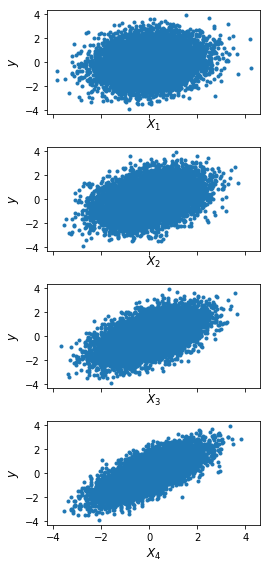

In [142]:
coeficients = np.linspace(0., 1., dim+1, endpoint=False)[1:]
# coeficients = np.ones((dim,))

n_plot = 10000
x = np.asarray(ot.ComposedDistribution(margins).getSample(n_plot))
y = sum_func(x, coeficients)

fig, axes = plt.subplots(dim, 1, sharex=True, sharey=True, figsize=(4, 2*dim))
for i in range(dim):
    ax = axes[i]
    ax.plot(x[:, i], y, '.')
    ax.set_xlabel(r'$X_%d$' % (i+1), fontsize=12)
    ax.set_ylabel(r'$y$', fontsize=12)
fig.tight_layout()

#### Copula families
We now consider only Gaussian dependencies for this example

In [143]:
families = np.zeros((dim, dim), dtype=int)
for i in range(1, dim):
    for j in range(i):
        families[i, j] = 1

## Estimations
We create an instance of the main class for conservative estimate, and we define a q_func object for the quantile as a quantity of interest

In [144]:
from dependence import ConservativeEstimate, quantile_func

quant_estimate = ConservativeEstimate(model_func=sum_func, margins=margins, families=families)

alpha = 0.01
q_func = quantile_func(alpha)

First, we compute the quantile at independence

In [145]:
n = 2000
indep_result = quant_estimate.independence(n_input_sample=n, q_func=q_func, random_state=random_state)

In [146]:
indep_result.compute_bootstrap(1000)
boot_std = indep_result.bootstrap_sample.std()
boot_mean = indep_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -4.66 with a C.O.V at 5.4 %


### Grid Search Approach
Firstly, we consider a grid search approach in order to compare the perfomance with the iterative algorithm.

In [147]:
K = 100
grid_type = 'lhs'
grid_result = quant_estimate.gridsearch_minimize(n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                 q_func=q_func, random_state=random_state)

In [148]:
min_result = grid_result.min_result
min_result.compute_bootstrap(1000)
boot_std = min_result.bootstrap_sample.std()
boot_mean = min_result.bootstrap_sample.mean()
print('Quantile at independence: %.2f with a C.O.V at %.1f %%' % (boot_mean, abs(boot_std/boot_mean)*100.))

Quantile at independence: -7.96 with a C.O.V at 3.1 %


In [149]:
if dim == 2:
    fig, ax = plt.subplots()
    ax.plot(grid_result.dep_params, grid_result.quantities)

### Iterative Approach
Now lets see how good we can be with the iterative appraoch.

In [ ]:
K = 100
grid_type = 'lhs'
grid_result = quant_estimate.iterative_minimize(max_n_params=5, n_dep_param=K, n_input_sample=n, grid_type=grid_type, 
                                                q_func=q_func, random_state=random_state)